# Testing UniRef Model

In [1]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import numpy as np

# Load model
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

# Load into GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval() 

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.12.layer.0.SelfAttention.q.weight', 'decoder.block.21.layer.0.SelfAttention.v.weight', 'decoder.block.11.layer.0.SelfAttention.q.weight', 'decoder.block.18.layer.2.DenseReluDense.wo.weight', 'decoder.block.4.layer.1.EncDecAttention.v.weight', 'decoder.block.22.layer.1.EncDecAttention.v.weight', 'decoder.block.5.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.22.layer.0.layer_norm.weight', 'decoder.block.19.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.0.SelfAttention.q.weight', 'decoder.block.17.layer.0.SelfAttention.o.weight', 'decoder.block.9.layer.1.EncDecAttention.k.weight', 'decoder.block.18.layer.0.SelfAttention.v.weight', 'decoder.block.7.layer.0.layer_norm.weight', 'decoder.block.22.layer.2.DenseReluDense.wi.weight', 'decoder.block.23.layer.1.EncDecAttention.o.weight', 'decoder.block.16.layer

In [2]:
# Tokenize, encode, and load example sequences
ex_seq = ["A T W","A T E"]
ex_seq = [re.sub(r"[UZOB]", "X", sequence) for sequence in ex_seq]
ids = tokenizer.batch_encode_plus(ex_seq, add_special_tokens=True, padding=True)
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

# Extract sequence features
with torch.no_grad():
    embedding = model(input_ids=input_ids,attention_mask=attention_mask)
embedding = embedding.last_hidden_state.cpu().numpy()

# Remove padding and special tokens
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    features.append(seq_emd)
len(features)

2

# Encoding Real Protein Sequences

In [3]:
from Bio import SeqIO

# Use biopython to parse fasta file and append sequences to list
sequences = []
with open("sequence.fasta") as file:
    for seq in SeqIO.parse(file, 'fasta'):

        # Add space after each character so each amino acid is vectorized
        seq = str(seq.seq)
        seq = ' '.join([*seq])
        sequences.append(seq)

# Use two sequences for testing
seq1 = sequences[4]
seq2 = sequences[6]
sequences = [seq1, seq2]

In [4]:
# Tokenize, encode, pad
ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True)
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

# Extract sequence features
with torch.no_grad():
    embedding = model(input_ids=input_ids,attention_mask=attention_mask)  #decoder_input_ids for decoder weights
embedding = embedding.last_hidden_state.cpu().numpy()

# Remove padding and special tokens
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    features.append(seq_emd)
len(features)

2

Number of vectors is half the length of a sequence with individual amino acids due to the space characters delineating each residue.

# Finding Significant Cosine Similarity Between Embedded Amino Acids

In [7]:
import numpy as np
from numpy.linalg import norm

# Find cosine similarity distribution for a character-by-character sequence comparison
cos_scores = []
for i, vec1 in enumerate(features[0]):
    vec2 = features[1][i]
    cos_sim = round(np.dot(vec1,vec2)/(norm(vec1)*norm(vec2)), 5)
    cos_scores.append(round(cos_sim*10, 6))

In [10]:
cos_scores

[8.5983,
 7.0268,
 5.9523,
 5.176,
 4.4469,
 5.7211,
 5.6482,
 4.43,
 2.9363,
 3.7262,
 2.5039,
 1.7854,
 1.9748,
 1.9162,
 1.7377,
 2.4665,
 2.2286,
 3.1379,
 2.8063,
 2.4457,
 1.7582,
 2.7485,
 2.4891,
 3.1942,
 1.6487,
 2.9611,
 1.4074,
 4.1713,
 2.9922,
 3.1869,
 2.1519,
 2.6427,
 3.0923,
 2.7617,
 2.8086,
 2.4358,
 2.7747,
 2.4366,
 3.6494,
 4.0328,
 2.6606,
 3.4515,
 3.2807,
 0.9205,
 2.4066,
 1.0731,
 3.2655,
 2.5612,
 3.992,
 2.463,
 2.8866,
 3.2599,
 2.9031,
 2.6069,
 2.5716,
 2.9387,
 4.5248,
 3.0825,
 3.2457,
 3.1584,
 4.9828,
 2.982,
 4.074,
 3.1966,
 3.273,
 3.9148,
 2.9126,
 3.0169,
 4.4429,
 3.9146,
 4.7129,
 3.1841,
 2.3081,
 2.0514,
 1.9267,
 1.6226,
 1.3826,
 3.5773,
 1.7559,
 2.0268,
 2.6636,
 2.6765,
 2.6828,
 2.656,
 3.3921,
 3.1768,
 3.3888,
 1.5821,
 3.6093,
 2.9272,
 1.7023,
 2.3085,
 1.7161,
 1.3289,
 5.1029,
 3.2737,
 1.9569,
 2.4454,
 2.4043,
 2.285,
 2.1828,
 4.0669,
 3.2298,
 2.6966,
 2.7624,
 1.9787,
 2.9045,
 3.5476,
 3.0331,
 3.2409,
 3.7784,
 1.2074,
 4

In [8]:
# BLOSUM64 matrix
blosum = [[4,0,-2,-1,-2,0,-2,-1,-1,-1,-1,-2,-1,-1,-1,1,0,0,-3,-2],
[0,9,-3,-4,-2,-3,-3,-1,-3,-1,-1,-3,-3,-3,-3,-1,-1,-1,-2,-2],
[-2,-3,6,2,-3,-1,-1,-3,-1,-4,-3,1,-1,0,-2,0,-1,-3,-4,-3],
[-1,-4,2,5,-3,-2,0,-3,1,-3,-2,0,-1,2,0,0,-1,-2,-3,-2],
[-2,-2,-3,-3,6,-3,-1,0,-3,0,0,-3,-4,-3,-3,-2,-2,-1,1,3],
[0,-3,-1,-2,-3,6,-2,-4,-2,-4,-3,0,-2,-2,-2,0,-2,-3,-2,-3],
[-2,-3,-1,0,-1,-2,8,-3,-1,-3,-2,1,-2,0,0,-1,-2,-3,-2,2],
[-1,-1,-3,-3,0,-4,-3,4,-3,2,1,-3,-3,-3,-3,-2,-1,3,-3,-1],
[-1,-3,-1,1,-3,-2,-1,-3,5,-2,-1,0,-1,1,2,0,-1,-2,-3,-2],
[-1,-1,-4,-3,0,-4,-3,2,-2,4,2,-3,-3,-2,-2,-2,-1,1,-2,-1],
[-1,-1,-3,-2,0,-3,-2,1,-1,2,5,-2,-2,0,-1,-1,-1,1,-1,-1],
[-2,-3,1,0,-3,0,1,-3,0,-3,-2,6,-2,0,0,1,0,-3,-4,-2],
[-1,-3,-1,-1,-4,-2,-2,-3,-1,-3,-2,-2,7,-1,-2,-1,-1,-2,-4,-3],
[-1,-3,0,2,-3,-2,0,-3,1,-2,0,0,-1,5,1,0,-1,-2,-2,-1],
[-1,-3,-2,0,-3,-2,0,-3,2,-2,-1,0,-2,1,5,-1,-1,-3,-3,-2],
[1,-1,0,0,-2,0,-1,-2,0,-2,-1,1,-1,0,-1,4,1,-2,-3,-2],
[0,-1,-1,-1,-2,-2,-2,-1,-1,-1,-1,0,-1,-1,-1,1,5,0,-2,-2],
[0,-1,-3,-2,-1,-3,-3,3,-2,1,1,-3,-2,-2,-3,-2,0,4,-3,-1],
[-3,-2,-4,-3,1,-2,-2,-3,-3,-2,-1,-4,-4,-2,-3,-3,-2,-3,11,2],
[-2,-2,-3,-2,3,-3,2,-1,-2,-1,-1,-2,-3,-1,-2,-2,-2,-1,2,7]]

# Find BLOSUM score distribution for a character-by-character sequence comparison
chars = 'ACDEFGHIKLMNPQRSTVWY'
blosum_scores = []
for i, char1 in enumerate(''.join(seq1.split(' '))):
    index1 = chars.index(char1)
    char2 = ''.join(seq2.split(' '))[i]
    index2 = chars.index(char2) 
    matrix_score = blosum[index1][index2]
    blosum_scores.append(matrix_score)


Text(0, 0.5, 'Frequency')

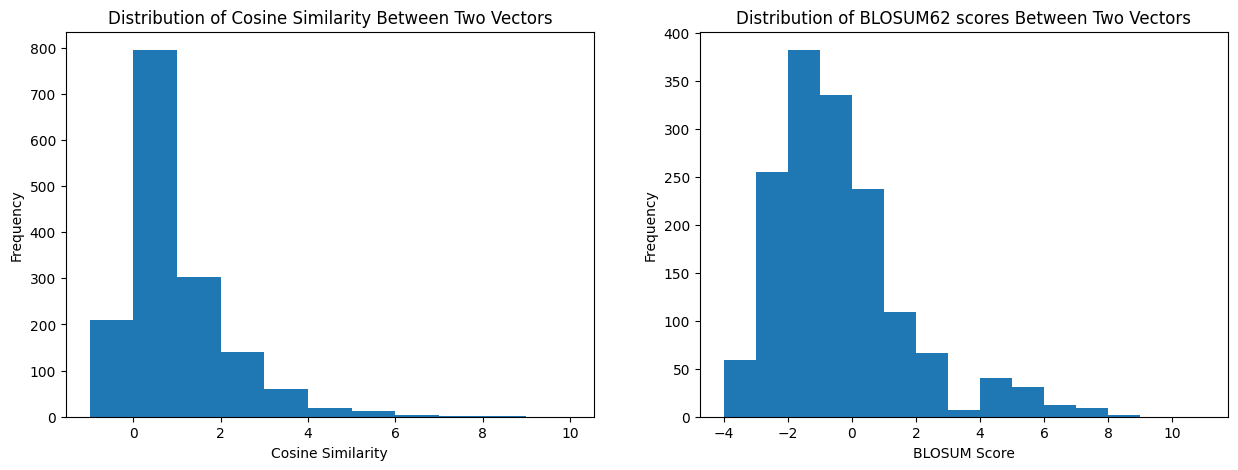

In [21]:
import matplotlib.pyplot as plt

# Compare distribution of cosine scores to distribution of BLOSUM scores
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(cos_scores, bins = [i for i in range(-1, 11)])
axes[0].set_title('Distribution of Cosine Similarity Between Two Vectors')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[1].hist(blosum_scores, bins = [i for i in range(-4, 12)])
axes[1].set_title('Distribution of BLOSUM62 scores Between Two Vectors')
axes[1].set_xlabel('BLOSUM Score')
axes[1].set_ylabel('Frequency')

In [19]:
[i*0.5 for i in range(-1, 11)]

[-0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]